In [1]:
import numpy as np
import copy
from scipy import stats
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
import matplotlib as mpl
import matplotlib.colors as mcolors
import pyart
import cmocean
experiment = "MBC_FIX"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)


In [3]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [4]:
def get_coords(src_model,ds):
   
    lon = ds.longitude.values
    lat = ds.latitude.values
                    
    # REGULARLY SPACED LAT/LON, can extrapolate outer corner bounds
    clon = (lon[:-1] + lon[1:])/2
    clat = (lat[:-1] + lat[1:])/2            
    clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
    clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])

    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    
    return lat,lon,clat,clon,chuk_mask

In [5]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] 
            + mod_dict[src_model]['fil_pre'] 
            + '_' + mod_dict[src_model]['ssh_var'] 
            + '_1993-2019_clim.nc')
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
        
    return ds

In [6]:
def plot_ssh(clon,clat,lon,lat,ssh,vmin,vmax,cmap,norm,c_inc):
    
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    C = ax.pcolormesh(clon, clat, ssh,cmap=cmap, norm=norm,transform=ccrs.PlateCarree())
    
    levels = cf*np.round(np.arange(vmin,vmax+c_inc/2,c_inc), decimals=2)  
    CS = ax.contour(lon,lat,ssh,levels, colors='k', transform=ccrs.PlateCarree())
    CS.monochrome = True
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',facecolor='blanchedalmond')
    ax.add_feature(land_50m,zorder=50)
    ax.coastlines('50m',zorder=50)
    
    outline_nep_domain(ax,nep_clon,nep_clat)

    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = True
    gl.top_labels = False

        
    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
            
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    if (nrow == 1) and (ncol > 0):
        
        pos = ax.get_position()
       
        if ncol == 1:
            x_space = 0.03
            pos2 = fig.axes[0].get_position()
            cbar_x = pos2.x0+x_space*(pos.width + pos2.width)
            cbar_wid = pos.width + pos2.width - (2*x_space)*(pos.width + pos2.width)
            cbar_levs = levels[::2]
            
        elif ncol == 3:
            cbar_x = pos.x0+.05*pos.width
            cbar_wid = (0.9)*pos.width
            cbar_levs = levels
        
        cax = fig.add_axes([cbar_x, pos.y0-.2*pos.height, cbar_wid, .1*pos.height])
        cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
        cbar.ax.set_xticks(cbar_levs)
        cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
        cax.plot([levels[levels<-0.01]]*2, [0, 1], '--k')
        cbar.ax.tick_params(labelsize=16)
        cax.set_xlabel('centimeters',fontsize=20)
    
    # STATISTICS
    if ncol == 3:
        stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nCorr: ' + f'{corr[0]:.2f}'
        ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)

    # Titles
    if ncol == 0:
        title_text = 'NEP10k (' + mod_dict['NEP']['ssh_var'] + ')'
    #elif ncol == 1:
    elif ncol == 1:
        title_text = comp_prod + ' (' + mod_dict[comp_prod]['ssh_var'] + ')'
    else:
        title_text = 'NEP10k - ' + comp_prod
        
    ax.set_title(title_text, fontsize=28)
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)          
    
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon), 
                   np.min(nep_clat), 70], crs=ccrs.PlateCarree())  
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
  

In [7]:
def calc_stats(nep_val_stats, comp_val_stats, area_val):
    # CALCULATE STATISTICS
    nan_idx = ~np.isnan(nep_val_stats)*~np.isnan(comp_val_stats)
    
    # Mean Bias
    mean_bias = np.nanmean((nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    mean_bias = np.nansum(((nep_val_stats*area_val)[nan_idx]-(comp_val_stats*area_val)[nan_idx])/np.nansum(area_val[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', mean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((nep_val_stats-comp_val_stats)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    rmse = np.sqrt(np.sum((((nep_val_stats-comp_val_stats)**2)*area_val)[nan_idx]/np.sum(area_val[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', rmse)
        
    # Median absolute error
    medae = np.nanmedian(np.abs(nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    corr = stats.pearsonr(nep_val_stats[nan_idx].ravel(), comp_val_stats[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)
    
    return mean_bias, rmse, medae, corr

In [8]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

In [9]:
mod_dict = {'NEP':{'dir':f'/work/Utheri.Wagura/NEP/plotting/Figure_5/{experiment}/',
                   'fil_pre':'nep',
                   'ssh_var':'ssh',},
            'CMEMS Altimetry':{'dir':'/work/role.medgrp/NEP/plotting/Figure_5/',
                   'fil_pre':'CMEMS',
                   'ssh_var':'adt',},
            'GLORYS12':{'dir':'/work/role.medgrp/NEP/plotting/Figure_5/',
                      'fil_pre':'glorys',
                      'ssh_var':'zos',}}

plot_labels = ['a','b','c','d','e','f']

cf = 100 # conversion factor to other units - 100 for meters to centimeters

cmap = cmap_in = 'pyart_HomeyerRainbow'
bounds = cf*np.linspace(-.5, .5, 21)
norm = mcolors.BoundaryNorm(bounds, 256, extend='both')

cmap2 = cmocean.cm.balance
bounds = cf*np.linspace(-.1, .1, 13)
norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')


/work/Utheri.Wagura/NEP/plotting/Figure_5/MBC_FIX/nep_ssh_1993-2019_clim.nc
CMEMS Altimetry
/work/role.medgrp/NEP/plotting/Figure_5/CMEMS_adt_1993-2019_clim.nc
MEAN BIAS: 0.3594731478405118
AREA-WEIGHTED MEAN BIAS: 0.39140310999891753
RMSE: 3.8422038514137347
AREA-WEIGHTED RMSE: 3.9496030078151643
MEDIAN ABSOLUTE ERROR: 2.0924369101495177
CORRELATION: PearsonRResult(statistic=0.9835682853457894, pvalue=0.0)
GLORYS12
/work/role.medgrp/NEP/plotting/Figure_5/glorys_zos_1993-2019_clim.nc
MEAN BIAS: -0.021957323926109825
AREA-WEIGHTED MEAN BIAS: 0.0007239976352627353
RMSE: 3.748182318807798
AREA-WEIGHTED RMSE: 3.8424888272294724
MEDIAN ABSOLUTE ERROR: 1.9050841670702532
CORRELATION: PearsonRResult(statistic=0.9843119066202943, pvalue=0.0)


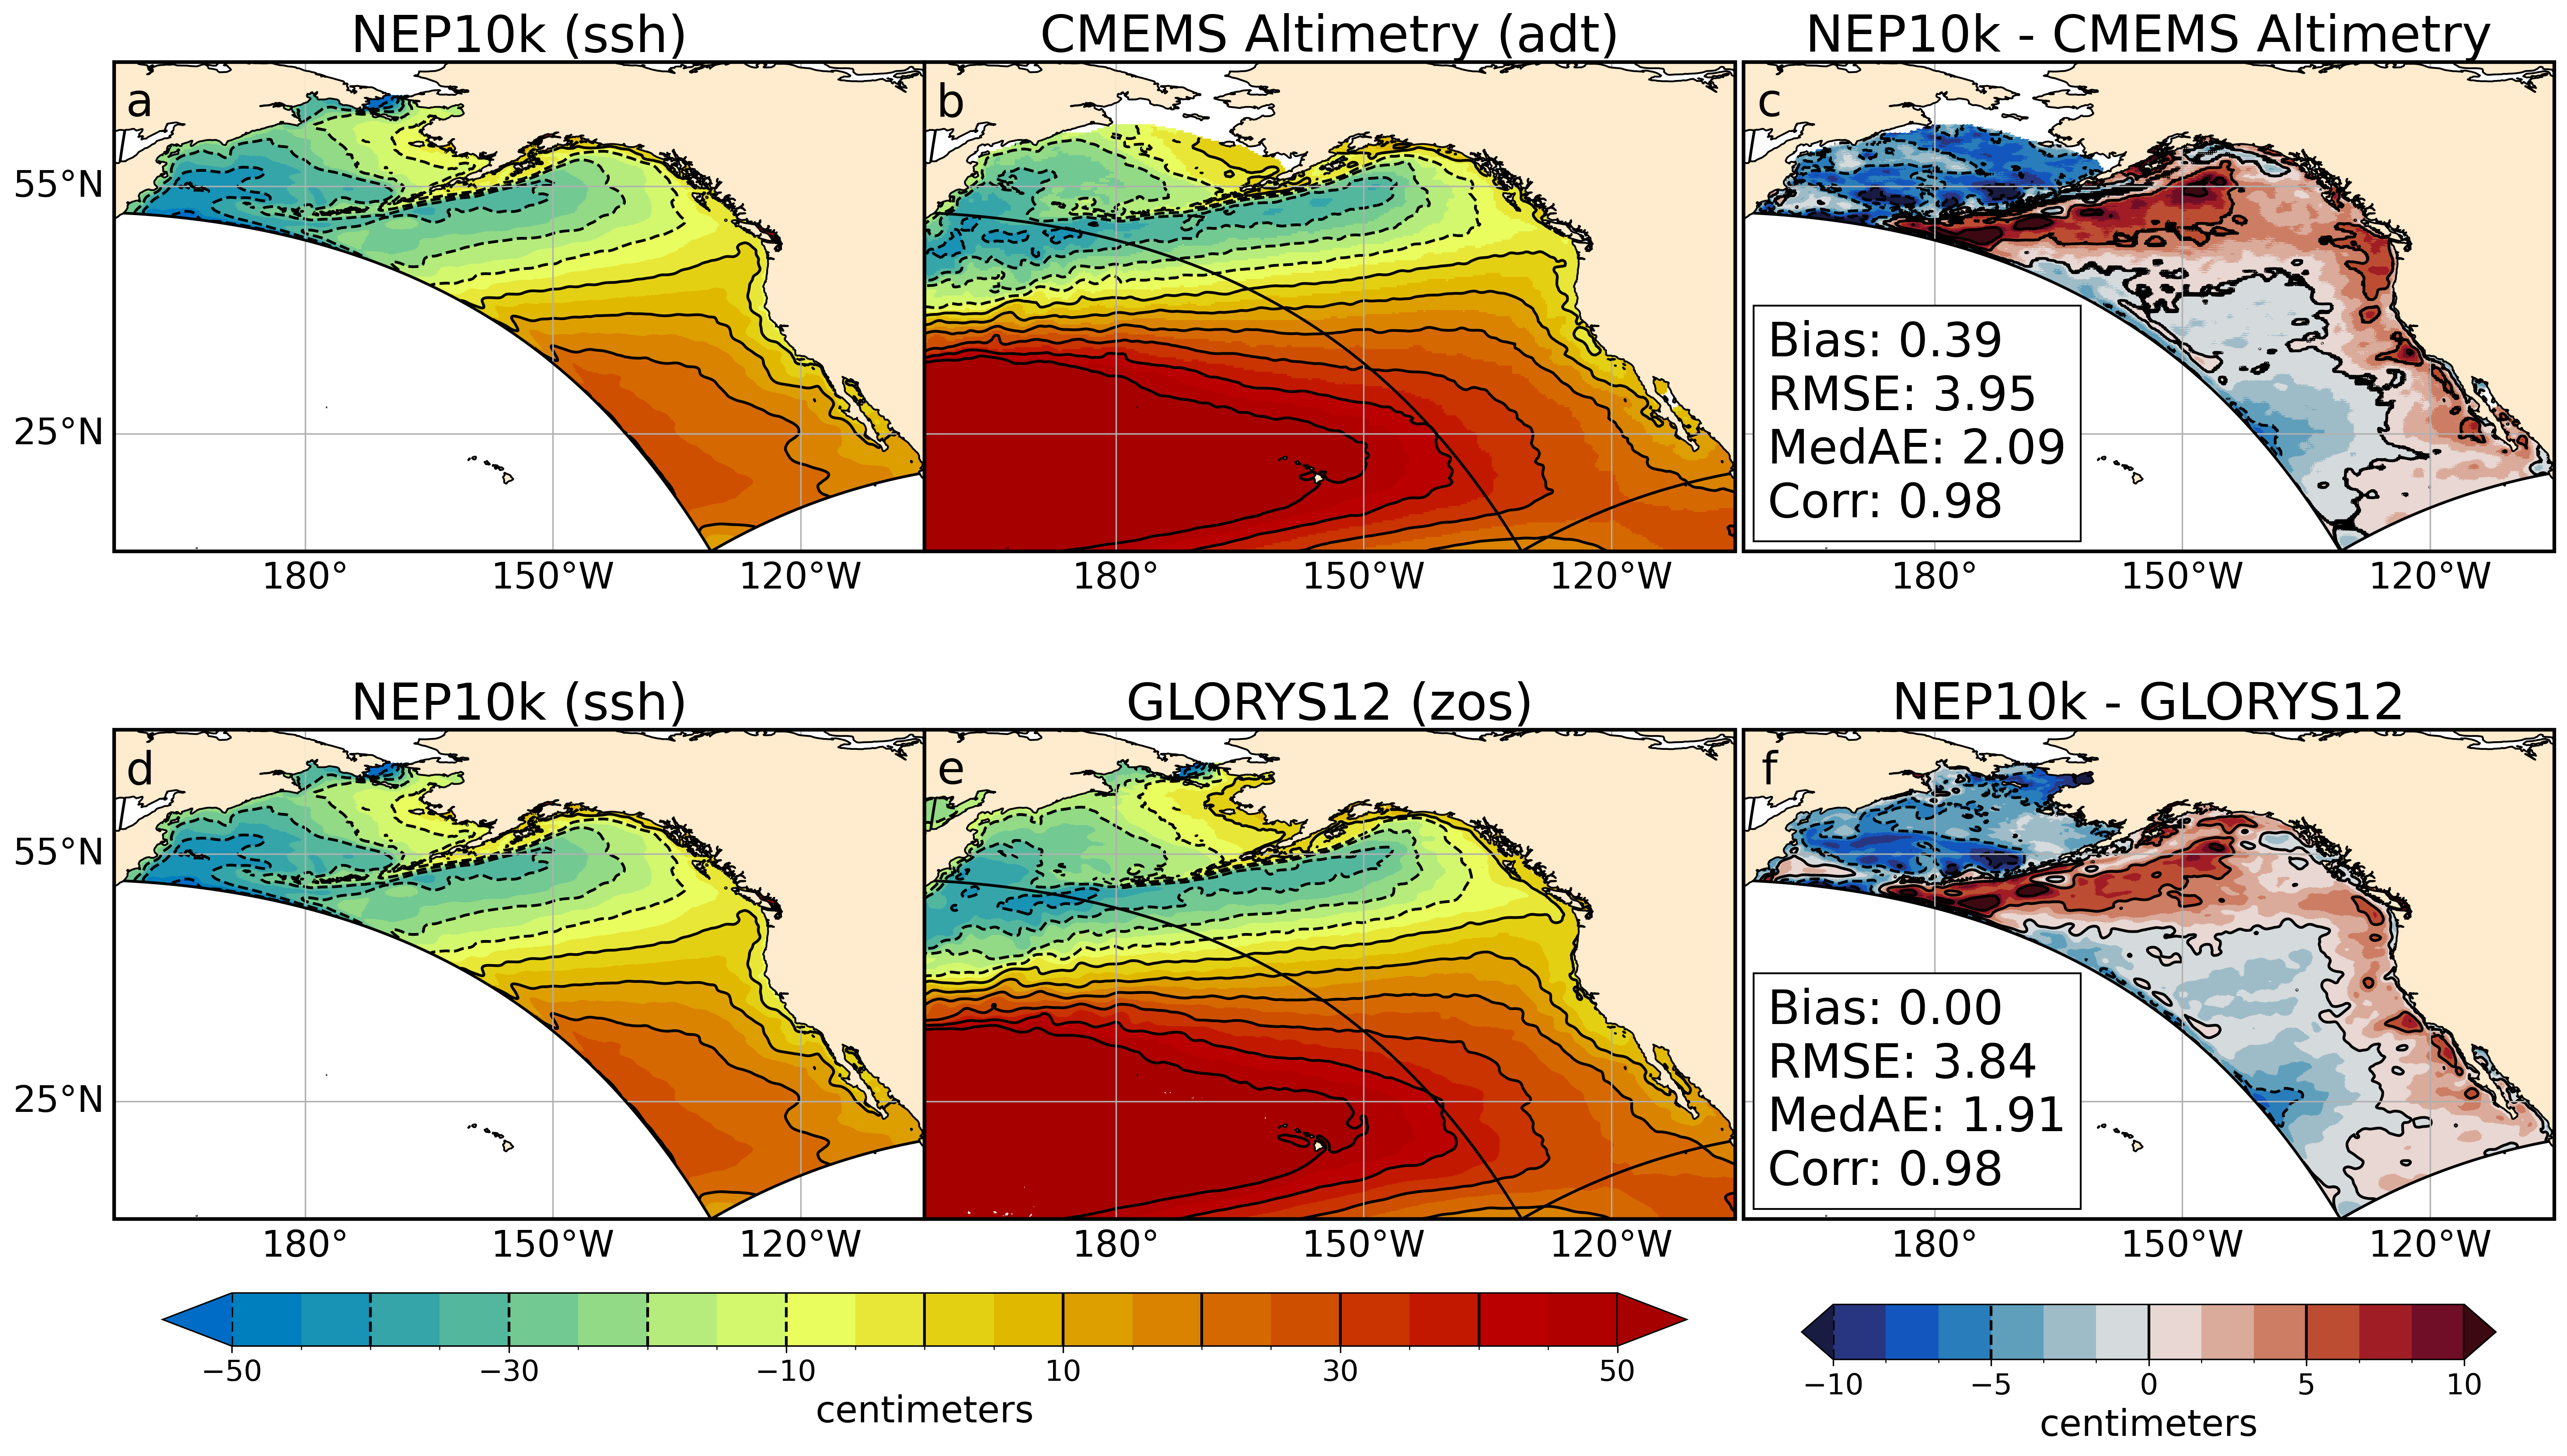

In [10]:
print_stats = True
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)
heights = [7,7,1]
widths = [10,10,.1,10]
const_offset = 500

for season in ['mean']:
    fig = plt.figure(figsize=(24,14),dpi=300)
    spec = fig.add_gridspec(ncols=4, nrows=3,wspace=0,hspace=0.3,height_ratios=heights,width_ratios=widths)
    ds_nep = get_model_ds('NEP')
    
    nlab = 0
    for comp_prod,nrow in zip(['CMEMS Altimetry','GLORYS12'],range(2)):
        ncol = 0
        print(comp_prod)
        ds_comp = get_model_ds(comp_prod) 
        lat,lon,clat,clon,chuk_mask = get_coords(comp_prod,ds_comp)
  
        # reference values
        ref_ssh = cf*ds_comp[mod_dict[comp_prod]['ssh_var']].values.squeeze()
        comp_lsm = ~np.isnan(ref_ssh[0,:].squeeze())
        
        # NEP Values
        nep_ssh = cf*ds_nep[mod_dict['NEP']['ssh_var']].values.squeeze()
                
        # regrid GLORYS and CMEMS to NEP
        # create regrid object: Ref -> NEP
        sourcefield, destfield, regrid = create_regrid_obj(clon,clat,comp_lsm,nep_clon,nep_clat)
        
        nt1,nj,ni = nep_ssh.shape
        comp_val_out = np.zeros((nt1,nj,ni))
        for nt in range(nt1):
            sourcefield.data[...] = ref_ssh[nt,:].squeeze() + const_offset
            destfield = regrid(sourcefield, destfield)
            tmp_val = copy.deepcopy(destfield.data)
            tmp_val[tmp_val==0] = np.nan
            comp_val_out[nt,:] = tmp_val - const_offset
            
        # need to isolate NEP region for the normalization. Need an LSM and area field
        # create regrid object: NEP -> OISST
        sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,lsm,clon,clat)
        sourcefield.data[...] = lsm + const_offset
        destfield = regrid(sourcefield, destfield)
        tmp_val = copy.deepcopy(destfield.data)
        tmp_val[tmp_val==0] = np.nan
        lsm_out = tmp_val - const_offset
        lsm_out[lsm_out>.5]=1
        lsm_out[lsm_out<.5]=0
        
        # Get area for weighted statistics 
        sourcefield.data[...] = nep_area + const_offset
        destfield = regrid(sourcefield, destfield)
        tmp_val = copy.deepcopy(destfield.data)
        tmp_val[tmp_val==0] = np.nan
        area_out = tmp_val - const_offset
        
        # Normalize datasets: get rid of Chuckchi, omit nan values, area weight mean
        # NEP
        nep_ssh[:,nep_lat>66] = np.nan
        nas_nep = ~np.isnan(nep_ssh)
        area_full = np.tile(nep_area[np.newaxis,:,:],(12,1,1))
        norm_nep_native = np.nansum(nep_ssh[nas_nep]*area_full[nas_nep])/np.sum(area_full[nas_nep])
        nep_ssh = nep_ssh - norm_nep_native
        
        # Native reference dataset
        ref_ssh[:,lat>66,:] = np.nan
        nas_ref = ~np.isnan(ref_ssh)
        area_full = np.tile(area_out[np.newaxis,:,:],(12,1,1))
        norm_ref_native = np.nansum(ref_ssh[nas_ref]*area_full[nas_ref])/np.nansum(area_full[nas_ref])
        ref_ssh = ref_ssh - norm_ref_native 
        
        # Regridded reference dataset
        comp_val_out[:,nep_lat>66] = np.nan
        nas_ref_regrid = ~np.isnan(comp_val_out)
        area_full = np.tile(nep_area[np.newaxis,:,:],(12,1,1))
        norm_ref_nep = np.nansum(comp_val_out[nas_ref_regrid]*area_full[nas_ref_regrid])/np.nansum(area_full[nas_ref_regrid])
        comp_val_out = comp_val_out - norm_ref_nep
        
        # SEASONAL SUBSETTING
        if season == 'JFM':
            comp_val_out = comp_val_out[:3,:]
            ref_ssh = ref_ssh[:3,:]
            nep_ssh = nep_ssh[:3,:]

        elif season == 'JAS':
            comp_val_out = comp_val_out[6:9,:]
            ref_ssh = ref_ssh[6:9,:]
            nep_ssh = nep_ssh[6:9,:]
            
        comp_diff_val = copy.deepcopy(comp_val_out)
        comp_diff_val = np.mean(comp_diff_val,axis=0)
        #comp_diff_val[lsm==0] = np.nan
        
        nep_diff_val = copy.deepcopy(nep_ssh)
        nep_diff_val = np.mean(nep_diff_val,axis=0)
        #nep_diff_val[lsm==0] = np.nan
        
        # take time mean of climatology
        ref_ssh = np.mean(ref_ssh,axis=0)
        nep_ssh = np.mean(nep_ssh,axis=0)
        
        # PLOT NEP on native grid
        plot_ssh(nep_clon,nep_clat,nep_lon,nep_lat,nep_ssh,-.5,.5,cmap,norm,.1)
        
        ncol+=1
        nlab+=1
            
        plot_ssh(clon,clat,lon,lat,ref_ssh,-.5,.5,cmap,norm,.1)
        
        ncol+=2
        nlab+=1
        
        mean_bias, rmse, medae, corr = calc_stats(nep_diff_val,comp_diff_val,nep_area)
        
        plot_ssh(nep_clon,nep_clat,nep_lon,nep_lat,nep_diff_val-comp_diff_val,-.1, .1, cmap2,norm2,.05 )
        nlab+=1
        
   
    fig_str = f'/work/Utheri.Wagura/NEP/plotting/Figure_5/{experiment}/Figure5_NEP_Altimetry_GLORYS_SSH_comp_1993-2019_mean'

    plt.savefig(fig_str)
    